In [7]:
# %load simple_convnet.py
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """简单的ConvNet

    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 输入大小（MNIST的情况下为784）
    hidden_size_list : 隐藏层的神经元数量的列表（e.g. [100, 100, 100]）
    output_size : 输出大小（MNIST的情况下为10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 指定权重的标准差（e.g. 0.01）
        指定'relu'或'he'的情况下设定“He的初始值”
        指定'sigmoid'或'xavier'的情况下设定“Xavier的初始值”
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 生成层
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()
        
     #进行识别
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """求损失函数
        参数x是输入数据、t是教师标签
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """求各个参数相较于损失函数梯度（数值微分）

        Parameters
        ----------
        x : 输入数据
        t : 教师标签

        Returns
        -------
        具有各层的梯度的字典变量
            grads['W1']、grads['W2']、...是各层的权重的梯度
            grads['b1']、grads['b2']、...是各层的偏置的梯度
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """求梯度（误差反向传播法）

        Parameters
        ----------
        x : 输入数据
        t : 教师标签

        Returns
        -------
        具有各层的梯度的字典变量
            grads['W1']、grads['W2']、...是各层的权重的梯度
            grads['b1']、grads['b2']、...是各层的偏置的梯度
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 设定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
    
       #将程序运行中的对象保存为文件 
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

train loss:2.29973546395
=== epoch:1, train acc:0.238, test acc:0.258 ===
train loss:2.29821803452
train loss:2.29354970511
train loss:2.2874567495
train loss:2.28182253053
train loss:2.26360610298
train loss:2.25266817887
train loss:2.2421719743
train loss:2.2218394938
train loss:2.20165269682
train loss:2.15958988042
train loss:2.12098115631
train loss:2.07081824545
train loss:2.00797757294
train loss:1.95463208133
train loss:1.90412990723
train loss:1.89689630515
train loss:1.83434518498
train loss:1.75652624067
train loss:1.65839254275
train loss:1.51302945668
train loss:1.48376207044
train loss:1.38726366743
train loss:1.30764258525
train loss:1.39473648888
train loss:1.12594176921
train loss:1.20995102427
train loss:1.12544675194
train loss:1.01559139255
train loss:1.03688909699
train loss:0.91524209135
train loss:0.763939559343
train loss:0.69667971385
train loss:0.932371011664
train loss:0.81206786943
train loss:0.556825714679
train loss:0.656653143606
train loss:0.777361375951

train loss:0.208402933329
train loss:0.190472282753
train loss:0.193574236612
train loss:0.256212008337
train loss:0.190495472253
train loss:0.265529999018
train loss:0.285806945647
train loss:0.179191514524
train loss:0.306628555097
train loss:0.269191360603
train loss:0.333689088871
train loss:0.266399687119
train loss:0.250609322099
train loss:0.174269890696
train loss:0.234112260935
train loss:0.194849146198
train loss:0.169603167275
train loss:0.228406084017
train loss:0.21748189662
train loss:0.209082877797
train loss:0.269623207971
train loss:0.104694929782
train loss:0.262725667711
train loss:0.206061680129
train loss:0.135679972483
train loss:0.180168045708
train loss:0.173150516533
train loss:0.132481273529
train loss:0.279467578318
train loss:0.211628515523
train loss:0.237256370794
train loss:0.144790729881
train loss:0.129928004652
train loss:0.102893951664
train loss:0.16135336358
train loss:0.234071081335
train loss:0.277171198116
train loss:0.224328075783
train loss:0.3

train loss:0.164603087548
train loss:0.0790832165611
train loss:0.104689381081
train loss:0.063031859832
train loss:0.170751228949
train loss:0.0536158225606
train loss:0.196784096313
train loss:0.194266371198
train loss:0.146648449356
train loss:0.120068466695
train loss:0.129519507218
train loss:0.102100676668
train loss:0.0767102904201
train loss:0.158662687043
train loss:0.14592312815
train loss:0.135058511445
train loss:0.144691837249
train loss:0.130152546337
train loss:0.131133200704
train loss:0.205688925509
train loss:0.0520124497502
train loss:0.069852572209
train loss:0.123045857811
train loss:0.129526403601
train loss:0.0957267127999
train loss:0.0905360772105
train loss:0.0910777218286
train loss:0.133195608053
train loss:0.0603762623957
train loss:0.106913409553
train loss:0.218340158303
train loss:0.108954926598
train loss:0.127511762049
train loss:0.061217798081
train loss:0.11230536638
train loss:0.0941894795494
train loss:0.16333950276
train loss:0.0737695173071
train

train loss:0.0330070124843
train loss:0.0563067426742
train loss:0.0760022846703
train loss:0.0592684402386
train loss:0.0948058990467
train loss:0.105335000593
train loss:0.141475318158
train loss:0.0803312551188
train loss:0.0976738029654
train loss:0.0761803044787
train loss:0.0918771377233
train loss:0.076478344655
train loss:0.0808996001853
train loss:0.0252407859457
train loss:0.0960797492082
train loss:0.0839805962954
train loss:0.129390795229
train loss:0.0618506702331
train loss:0.118414650855
train loss:0.0528659168188
train loss:0.0256976375696
train loss:0.101168614041
train loss:0.081583405175
train loss:0.0316641783206
train loss:0.0943507480854
train loss:0.102917392357
train loss:0.0656672120044
train loss:0.053518083962
train loss:0.0855076138867
train loss:0.0902469737898
train loss:0.0715506310258
train loss:0.0266284660204
train loss:0.0679039521041
train loss:0.076086387943
train loss:0.0562101196874
train loss:0.0977970244948
train loss:0.0915045026659
train loss:

train loss:0.0526966932622
train loss:0.179261297426
train loss:0.0627238433429
train loss:0.0543009394243
train loss:0.0581089345645
train loss:0.0559033981607
train loss:0.0211986717289
train loss:0.0345455071372
train loss:0.0597929017101
train loss:0.0363836809202
train loss:0.0320741439289
train loss:0.0652642253584
train loss:0.118254665287
train loss:0.0887712132014
train loss:0.0579751739819
train loss:0.0418917511007
train loss:0.0313487869838
train loss:0.0498271423172
train loss:0.121040188547
train loss:0.0192674652157
train loss:0.0589100638582
train loss:0.0659989301937
train loss:0.0231456625758
train loss:0.0920816988756
train loss:0.025827785594
train loss:0.0410394615684
train loss:0.031693875787
train loss:0.0676452661913
train loss:0.114625776915
train loss:0.115493232678
train loss:0.0359880019415
train loss:0.0653831905994
train loss:0.107625868623
train loss:0.0746749679939
train loss:0.017988314271
train loss:0.0939328245214
train loss:0.0450524553623
train loss

train loss:0.0612894340408
train loss:0.0641508191606
train loss:0.162204785878
train loss:0.0367429530396
train loss:0.0103496755362
train loss:0.0466658393725
train loss:0.116949608249
train loss:0.00667181808479
train loss:0.0171226982983
train loss:0.116672843099
train loss:0.0129114922609
train loss:0.0314848094152
train loss:0.0801394986353
train loss:0.025159490241
train loss:0.045209122618
train loss:0.0569658139401
train loss:0.0248624817358
train loss:0.0329079806646
train loss:0.110033304674
train loss:0.0554424898937
train loss:0.0367228940376
train loss:0.0257914589558
train loss:0.0772669974893
train loss:0.0566241722906
train loss:0.0620889582977
train loss:0.0471617681281
train loss:0.0737981009472
train loss:0.0202586004539
train loss:0.0403448542791
train loss:0.0429094322303
train loss:0.0537518373735
train loss:0.0307622695139
train loss:0.0548316990294
train loss:0.0484996303747
train loss:0.0104964023629
train loss:0.0468621150978
train loss:0.0154453569414
train 

train loss:0.0371647978309
train loss:0.121714011804
train loss:0.0396888434715
train loss:0.0777512539405
train loss:0.0280967956278
train loss:0.104662474167
train loss:0.0668411642294
train loss:0.0363503275259
train loss:0.0865723338587
train loss:0.123119712962
train loss:0.0438744219744
train loss:0.0215648956374
train loss:0.0343385383383
train loss:0.0361272294658
train loss:0.0790778258405
train loss:0.0729327920413
train loss:0.053392777515
train loss:0.0289360176729
train loss:0.0123905236479
train loss:0.026785993527
train loss:0.0194236982287
train loss:0.0133568232139
train loss:0.0105850341733
train loss:0.0440406429543
train loss:0.061819541988
train loss:0.00558365416029
train loss:0.0203596481697
train loss:0.0404651996791
train loss:0.0751424185911
train loss:0.0392884770047
train loss:0.0268543454855
train loss:0.0293271133324
train loss:0.0652178880303
train loss:0.0395512236643
train loss:0.0207695148049
train loss:0.0830188793144
train loss:0.042937260749
train l

train loss:0.147012067458
train loss:0.0245708544539
train loss:0.0808429730517
train loss:0.057782389831
train loss:0.0199260208214
train loss:0.0441799994596
train loss:0.0485863019933
train loss:0.0563287715413
train loss:0.0578160826426
train loss:0.0756314388476
train loss:0.02853989614
train loss:0.00466229915471
train loss:0.00605279395564
train loss:0.0168096930206
train loss:0.0623481776987
train loss:0.0115275649312
train loss:0.0576571172627
train loss:0.011097131531
train loss:0.0113433948907
train loss:0.083461414993
train loss:0.024640242252
train loss:0.0632629693532
train loss:0.0105552184707
train loss:0.0329402143712
train loss:0.0398028245961
train loss:0.0113936950738
train loss:0.0126285218136
train loss:0.0281396370421
train loss:0.0175044445751
train loss:0.0132314392423
train loss:0.0304900462466
train loss:0.0235161452912
train loss:0.0273546524768
train loss:0.00950789807327
train loss:0.0316044056371
train loss:0.0343780084996
train loss:0.00529379154456
trai

train loss:0.00877550652035
train loss:0.0391211805845
train loss:0.0210646800354
train loss:0.0270357874355
train loss:0.0128878953928
train loss:0.0297283815014
train loss:0.031045973719
train loss:0.0119290168124
train loss:0.019214335237
train loss:0.0505166666984
train loss:0.0286139937895
train loss:0.0136930976922
train loss:0.0176412644874
train loss:0.0283310606862
train loss:0.00772584133046
train loss:0.0200788778828
train loss:0.015717191304
train loss:0.0334036956909
train loss:0.0121638886162
train loss:0.00163418098004
train loss:0.031330788869
train loss:0.0239782228421
train loss:0.0171111456645
train loss:0.0214513443186
train loss:0.0102410489574
train loss:0.0249243134975
train loss:0.00481097243543
train loss:0.0638947951491
train loss:0.0557597364766
train loss:0.0615439448492
train loss:0.00525830994346
train loss:0.0431774916384
train loss:0.0102141820839
train loss:0.00558985962199
train loss:0.0138869075197
train loss:0.0142210350227
train loss:0.0630513498951

train loss:0.0165921535446
train loss:0.00457625040304
train loss:0.00384097918399
train loss:0.0192887256153
train loss:0.00989261731984
train loss:0.043404601668
train loss:0.0221650650586
train loss:0.0229054222017
train loss:0.0691196878094
train loss:0.0245092546716
train loss:0.00185666579381
train loss:0.0166197562809
train loss:0.0420696178969
train loss:0.016641205447
train loss:0.0615564039837
train loss:0.0187218957476
train loss:0.0200744023297
train loss:0.0581813897118
train loss:0.0189127073354
train loss:0.0361622484942
train loss:0.011299040338
train loss:0.0216422864045
train loss:0.0239131846826
train loss:0.0064607027401
train loss:0.0299845533816
train loss:0.00822789220501
train loss:0.0228974960981
train loss:0.0138201778244
train loss:0.00616503742814
train loss:0.0162192968172
train loss:0.0197434238159
train loss:0.0286389972712
train loss:0.0264591387066
train loss:0.0050715342818
train loss:0.0473825894068
train loss:0.0175761743574
train loss:0.018761754998

train loss:0.0254224135565
train loss:0.0360718876193
train loss:0.0170789634292
train loss:0.00968171788952
train loss:0.0225426338936
train loss:0.011864556051
train loss:0.0333653185587
train loss:0.0133328281544
train loss:0.0292563393667
train loss:0.0154489194614
train loss:0.0206837351523
train loss:0.0152835771408
train loss:0.0185109849698
train loss:0.00428708610325
train loss:0.0277307796383
train loss:0.0103523807324
train loss:0.0612041507604
train loss:0.0327825326134
train loss:0.0133146290031
train loss:0.0141994646243
train loss:0.0150938713931
train loss:0.0122072819817
train loss:0.00651639512529
train loss:0.00633291819073
train loss:0.00422401429466
train loss:0.0177014790905
train loss:0.00442920178361
train loss:0.00732471683497
train loss:0.0207234263411
train loss:0.00642170470959
train loss:0.00964221682382
train loss:0.00798528081459
train loss:0.0195081231147
train loss:0.0177677507616
train loss:0.0126523699644
train loss:0.0814644887758
train loss:0.022617

train loss:0.0144645649701
train loss:0.0207065558521
train loss:0.010025870013
train loss:0.00645815030844
train loss:0.021128509847
train loss:0.00304528686077
train loss:0.0305244352083
train loss:0.0615235750137
train loss:0.0318181178231
train loss:0.0496787890561
train loss:0.00633899673802
train loss:0.173349449496
train loss:0.0119929473214
train loss:0.00991011941639
train loss:0.0497996296447
train loss:0.00555602687862
train loss:0.0292644963104
train loss:0.0148824198335
train loss:0.00384657521779
train loss:0.0149104313403
train loss:0.0135895452402
train loss:0.0103097329017
train loss:0.0106255196604
train loss:0.0193388530138
train loss:0.0706236495479
train loss:0.0380932138775
train loss:0.0143641993174
train loss:0.0483639742998
train loss:0.0129642862034
train loss:0.0124542791023
train loss:0.031513346144
train loss:0.0270940685455
train loss:0.00413744841267
train loss:0.00835231416456
train loss:0.0549125154448
train loss:0.0552408656041
train loss:0.00477966005

train loss:0.00887763138657
train loss:0.00234389142538
train loss:0.0102926111971
train loss:0.0149173318593
train loss:0.0169680312244
train loss:0.0513069061973
train loss:0.0182389707435
train loss:0.00715237770156
train loss:0.0665859858671
train loss:0.00827681115783
train loss:0.00815863767978
train loss:0.0189248127142
train loss:0.0170753815895
train loss:0.00393986966285
train loss:0.00971584932817
train loss:0.00876822743512
train loss:0.00834662651596
train loss:0.0201703154649
train loss:0.00622683049782
train loss:0.00469328448302
train loss:0.0620845691847
train loss:0.00604799120058
train loss:0.00812940018261
train loss:0.00645561147669
train loss:0.00645309392223
train loss:0.00722493040768
train loss:0.00568146499754
train loss:0.00606492140319
train loss:0.00656651196334
train loss:0.0328734607607
train loss:0.0123260280717
train loss:0.0135231321326
train loss:0.0104137071758
train loss:0.00376153787438
train loss:0.00884005827068
train loss:0.00515200139187
train 

train loss:0.0406783686952
train loss:0.00403824007403
train loss:0.00518240836635
train loss:0.00325367460665
train loss:0.142599115796
train loss:0.00850513371015
train loss:0.0921156971242
train loss:0.00428279733198
train loss:0.0416919774165
train loss:0.0288407196951
train loss:0.0040871601705
train loss:0.0317574793162
train loss:0.05186183322
train loss:0.00680187919187
train loss:0.0160963581468
train loss:0.00667442056432
train loss:0.00411192537269
train loss:0.00984289371242
train loss:0.0218187385866
train loss:0.0107649182872
train loss:0.0215543684618
train loss:0.0307187304531
train loss:0.0119537132949
train loss:0.0456911421271
train loss:0.028543022201
train loss:0.0379714597963
train loss:0.00863742587872
train loss:0.00573772093436
train loss:0.0248024692404
train loss:0.0223079150145
train loss:0.0143402324703
train loss:0.00479990970887
train loss:0.015303018592
train loss:0.00186039012057
train loss:0.102132845749
train loss:0.0136978454561
train loss:0.00915210

train loss:0.00744143541844
train loss:0.0147889520912
train loss:0.00777502754414
train loss:0.00749142902795
train loss:0.0175172614185
train loss:0.0157338438676
train loss:0.00422268699059
train loss:0.00551394958288
train loss:0.00361177870645
train loss:0.0152498236885
train loss:0.00803664292738
train loss:0.0626410793659
train loss:0.00882983159447
train loss:0.0128280507454
train loss:0.00746696044822
train loss:0.0151132319384
train loss:0.0171963464223
train loss:0.00599402594303
train loss:0.0185142795074
train loss:0.0354173927996
train loss:0.0107731153475
train loss:0.00410420653451
train loss:0.00891285355755
train loss:0.00204954035769
train loss:0.016646500879
train loss:0.0146492718206
train loss:0.0163282442327
train loss:0.0044620920114
train loss:0.0596338183361
train loss:0.00345065228798
train loss:0.0103694734695
train loss:0.00405409376662
train loss:0.00261795056228
train loss:0.0019076049959
train loss:0.00718596322708
train loss:0.0043658862989
train loss:0

train loss:0.00551634893044
train loss:0.00223464017035
train loss:0.0126285836786
train loss:0.0285697888622
train loss:0.0121481606389
train loss:0.0198771605692
train loss:0.0184427852408
train loss:0.00621170293954
train loss:0.0105521923913
train loss:0.0808956380374
train loss:0.019954112078
train loss:0.0117419442759
train loss:0.00654073466987
train loss:0.00393631358237
train loss:0.0105694396108
train loss:0.00441408332973
train loss:0.00903058087444
train loss:0.0205869993318
train loss:0.0257611830976
train loss:0.00607411863291
train loss:0.010407102425
train loss:0.00202621700277
train loss:0.0122680542805
train loss:0.0150172257361
train loss:0.014611341863
train loss:0.00528335435525
train loss:0.0215092058205
train loss:0.0106924382824
train loss:0.0039481113774
train loss:0.0228357581926
train loss:0.00937476902565
train loss:0.00897105164758
train loss:0.00359243521674
train loss:0.00727897255603
train loss:0.00778519901191
train loss:0.0341932108975
train loss:0.009

train loss:0.0106368113836
train loss:0.00927777152951
train loss:0.00702441825853
train loss:0.00482306958266
train loss:0.00275196212634
train loss:0.00991570395698
train loss:0.00926045649756
train loss:0.0304433561146
train loss:0.0141050719006
train loss:0.00577322599606
train loss:0.00319141825923
train loss:0.00727466358851
train loss:0.00304386445937
train loss:0.0104642346436
train loss:0.00751318380342
train loss:0.00367110000071
train loss:0.00326572143824
train loss:0.0133593742174
train loss:0.0138449515269
train loss:0.00421785939357
train loss:0.000723470577549
train loss:0.0027389335923
train loss:0.00669322198086
train loss:0.00390800163274
train loss:0.0176123023826
train loss:0.00363961904543
train loss:0.00284472850482
train loss:0.00159442601756
train loss:0.00565631635947
train loss:0.0119080252052
train loss:0.00627527779841
train loss:0.004288830588
train loss:0.00865693680443
train loss:0.00738055603621
train loss:0.051264483793
train loss:0.0151903422449
train

train loss:0.00155722822544
train loss:0.0112887057264
train loss:0.00212891398781
train loss:0.0142073369191
train loss:0.00391736110538
train loss:0.0194207771914
train loss:0.0140581638135
train loss:0.0302529063361
train loss:0.00114097840562
train loss:0.00503532583744
train loss:0.00588640762981
train loss:0.0342059291141
train loss:0.00153140204139
train loss:0.00264629735282
train loss:0.0329663335654
train loss:0.00654489566285
train loss:0.00624743600415
train loss:0.00351016500105
train loss:0.00273437274404
train loss:0.00448526448938
train loss:0.00322805468737
train loss:0.00511542587679
train loss:0.0145189728485
train loss:0.0035953293505
train loss:0.0086807816135
train loss:0.000949801809512
train loss:0.00329605200433
train loss:0.0237141069659
train loss:0.00293000947204
train loss:0.0215634369554
train loss:0.0172040605197
train loss:0.0218843868023
train loss:0.00352161070009
train loss:0.00586692772082
train loss:0.00401523404872
train loss:0.00132905995509
train

train loss:0.00952484597255
train loss:0.000392033107935
train loss:0.0125258916248
train loss:0.00423284290508
train loss:0.00299773518631
train loss:0.00573015695741
train loss:0.00163474800242
train loss:0.00159529604994
train loss:0.00032019469066
train loss:0.00201076726771
train loss:0.011610649371
train loss:0.00558642206905
train loss:0.00709060996744
train loss:0.00152503806224
train loss:0.000955831058164
train loss:0.000939743646357
train loss:0.016431825803
train loss:0.00811912430706
train loss:0.00675719189993
train loss:0.00381938765445
train loss:0.00460389562788
train loss:0.00555958567525
train loss:0.00183509671679
train loss:0.0164224823617
train loss:0.0072554200173
train loss:0.00309611360819
train loss:0.0113641667837
train loss:0.000626641526644
train loss:0.00439158873882
train loss:0.00211484133969
train loss:0.0162011659097
train loss:0.0038170654672
train loss:0.00917801488578
train loss:0.0141593495117
train loss:0.00524132748669
train loss:0.00065053634742

train loss:0.0246683366518
train loss:0.00248045193073
train loss:0.000499553140837
train loss:0.122155970735
train loss:0.0088453040979
train loss:0.0101921119935
train loss:0.00871293625447
train loss:0.00728766841584
train loss:0.00223017662047
train loss:0.00634476791159
train loss:0.0043000730027
train loss:0.00281259614001
train loss:0.0023379710692
train loss:0.106832399758
train loss:0.00506705678284
train loss:0.00906986998492
train loss:0.00628998829302
train loss:0.00454946732042
train loss:0.00416329847924
train loss:0.00501932390995
train loss:0.00317942760737
train loss:0.0107050359665
train loss:0.0090100294322
train loss:0.00446030706891
train loss:0.00304342736079
train loss:0.00214509816416
train loss:0.00421016714396
train loss:0.00344302236367
train loss:0.00739998627818
train loss:0.00556279158139
train loss:0.0185403710719
train loss:0.00408458181604
train loss:0.00166884097121
train loss:0.0024138623588
train loss:0.00179077285413
train loss:0.0078724498567
train

train loss:0.0146641562567
train loss:0.00572652575541
train loss:0.00405736983365
train loss:0.070848782171
train loss:0.000471824064204
train loss:0.0105752619594
train loss:0.00311599126368
train loss:0.00715699172544
train loss:0.0164913630055
train loss:0.000457873329742
train loss:0.00245021084151
train loss:0.0036322014791
train loss:0.0212929072573
train loss:0.00495423339796
train loss:0.00178454535705
train loss:0.00415261544681
train loss:0.00686941484694
train loss:0.0116602883123
train loss:0.00226668245578
train loss:0.0335633229588
train loss:0.0327584854084
train loss:0.00860381911958
train loss:0.0118712606217
train loss:0.00237983950753
train loss:0.00503100990719
train loss:0.00078990250666
train loss:0.00682450199376
train loss:0.00453910672686
train loss:0.00582805741808
train loss:0.0107350329264
train loss:0.00302786911301
train loss:0.0206426778035
train loss:0.00189477267865
train loss:0.0044931847046
train loss:0.0128826470034
train loss:0.00406753040835
train

train loss:0.00469075723284
train loss:0.00129427834939
train loss:0.00672195954182
train loss:0.00118218455831
train loss:0.00499164798424
train loss:0.0104005507128
train loss:0.00231755501376
train loss:0.00724648421245
train loss:0.00510954230741
train loss:0.00084706426066
train loss:0.000876590986468
train loss:0.0045155533207
train loss:0.0309843612035
train loss:0.00366201345382
train loss:0.00283646998467
train loss:0.00923543500943
train loss:0.00185776337297
train loss:0.0172645355783
train loss:0.000323862285525
train loss:0.00657153577903
train loss:0.0125879045878
train loss:0.00328335487188
train loss:0.00585241376399
train loss:0.00196051411748
train loss:0.00191331947276
train loss:0.00173507920443
train loss:0.0060114913158
train loss:0.00670634628956
train loss:0.00428381667308
train loss:0.00248640686162
train loss:0.00687242644789
train loss:0.00732837023909
train loss:0.000773489875705
train loss:0.00158823888105
train loss:0.0030714460576
train loss:0.01277464017

train loss:0.00402227554772
train loss:0.00327781636911
train loss:0.00779807642773
train loss:0.00516786669988
train loss:0.00207427472424
train loss:0.00336263316424
train loss:0.0075098608174
train loss:0.0149620295159
train loss:0.00174397385861
train loss:0.000571909199279
train loss:0.00108399428912
train loss:0.00452662282613
train loss:0.00360212731508
train loss:0.000884754368043
train loss:0.0020668958751
train loss:0.0158309167661
train loss:0.00600869472361
train loss:0.0283903005998
train loss:0.000527015188784
train loss:0.015111374998
train loss:0.00104273839199
train loss:0.00440849589798
train loss:0.00406804491
train loss:0.0111075856846
train loss:0.00701000406251
train loss:0.0106848534022
train loss:0.00101851302668
train loss:0.0111361039059
train loss:0.00479912698736
train loss:0.00292557001223
train loss:0.0053686500388
train loss:0.00554261842571
train loss:0.00122772098294
train loss:0.0163300202355
train loss:0.0115771098168
train loss:0.00331797884639
train

train loss:0.0124916534818
train loss:0.00377479024503
train loss:0.0020523388506
train loss:0.00867784205914
train loss:0.00870632663463
train loss:0.00444329209551
train loss:0.013743758194
train loss:0.00060517804614
train loss:0.0043457577025
train loss:0.00675822857003
train loss:0.000738404723993
train loss:0.00912509561222
train loss:0.00280555790059
train loss:0.00439460387769
train loss:0.0229511242402
train loss:0.0108800628986
train loss:0.000585646767292
train loss:0.00948023473172
train loss:0.00571155253563
train loss:0.000988824834344
train loss:0.00170742106509
train loss:0.00449619333688
train loss:0.0056849990198
train loss:0.00437469003059
train loss:0.000688275407392
train loss:0.0051994865034
train loss:0.00896122014482
train loss:0.00281049104366
train loss:0.0117202456578
train loss:0.00201616885452
train loss:0.000935314874819
train loss:0.00419758830745
train loss:0.000664181038507
train loss:0.0029513871306
train loss:0.00255546267585
train loss:0.000799268781

train loss:0.00395026328584
train loss:0.000455014294022
train loss:0.000757257211332
train loss:0.0037581121579
train loss:0.00167077309799
train loss:0.00325693680138
train loss:0.00473831626779
train loss:0.00203137850299
train loss:0.00401708688998
train loss:0.00465662449828
train loss:0.00799043337289
train loss:0.00114810868364
train loss:0.004460247799
train loss:0.00124284769561
train loss:0.00072677544704
train loss:0.000957433884471
train loss:0.000108374777605
train loss:0.00327595714342
train loss:0.0023364194778
train loss:0.00308876533773
train loss:0.000190615637314
train loss:0.00459260844974
train loss:0.0129033767745
train loss:0.000855572911914
train loss:0.0108272911421
train loss:0.00622615918716
train loss:0.000202936480673
train loss:0.000706669607641
train loss:0.0013683681533
train loss:0.00201075970916
train loss:0.00734482872549
train loss:0.00656365016398
train loss:0.000200344451323
train loss:0.000522329985007
train loss:0.000876905539167
train loss:0.001

train loss:0.00857114888206
train loss:0.00638878950721
train loss:0.0115133419531
train loss:0.00252299853481
train loss:0.000694439692228
train loss:0.00451901412972
train loss:0.00390873721181
train loss:0.0003065955419
train loss:0.00150148565897
train loss:0.00182200784829
train loss:0.00438575621881
train loss:0.000542213560201
train loss:0.00146329442253
train loss:0.0203177341473
train loss:0.00552311985462
train loss:0.00210032224051
train loss:0.00139677667857
train loss:0.00164693873245
train loss:0.00243599699662
train loss:0.000381076874878
train loss:0.00539449837933
train loss:0.00279740449015
train loss:0.00077210870775
train loss:0.00232447493776
train loss:0.00546784167842
train loss:0.000573461184924
train loss:0.0135644987438
train loss:0.00337911643629
train loss:0.00123428123012
train loss:0.00581875482521
train loss:0.0089888710962
train loss:0.014657270577
train loss:0.000278412420533
train loss:0.00111581019108
train loss:0.00918614094659
train loss:0.001734710

train loss:0.00654150463631
train loss:0.000650435687486
train loss:0.00164836490489
train loss:0.000619738802888
train loss:0.000450813067063
train loss:0.0121167638844
train loss:0.00633643825203
train loss:0.00131696241436
train loss:0.00238832947037
train loss:0.00463507396744
train loss:0.00190011795494
train loss:0.00114096016777
train loss:0.00274958491773
train loss:0.0113303141864
train loss:0.00076724301328
train loss:0.00121313543624
train loss:0.00853364781598
train loss:0.00402203870917
train loss:0.00980012397788
train loss:0.00158391772182
train loss:0.00899927027557
train loss:0.00464390385765
train loss:0.0145425681268
train loss:0.00672182991606
train loss:0.00196641536392
train loss:0.00574886330761
train loss:5.4661297698e-05
train loss:0.00366863378432
train loss:0.0171129122803
train loss:0.0021113350753
train loss:0.00700670080623
train loss:0.00421424300612
train loss:0.0213264932926
train loss:0.00120289150521
train loss:0.0056832003077
train loss:0.00301603775

train loss:0.000687796697499
train loss:0.00321295687834
train loss:0.00896350614781
train loss:0.0184869759725
train loss:0.0200996817381
train loss:0.00185743550478
train loss:0.00102630264652
train loss:0.00137802873466
train loss:0.000220999368238
train loss:0.00100293145888
train loss:0.0051997418952
train loss:0.00170844040439
train loss:0.00467280149134
train loss:0.00451826108635
train loss:0.000293375987362
train loss:0.00044819296536
train loss:0.000818491122659
train loss:0.000985250439671
train loss:0.00172985074374
train loss:0.00208507887712
train loss:0.00207318903502
train loss:0.000903138176747
train loss:0.00275543627343
train loss:0.00373769751873
train loss:0.000814211011189
train loss:0.000883937806522
train loss:0.00724460256411
train loss:0.00576854262129
train loss:0.00935533332815
train loss:0.000802529016726
train loss:0.00923173372111
train loss:0.000605054723231
train loss:0.0225473031422
train loss:6.87449319365e-05
train loss:0.00181446168655
train loss:0.

train loss:0.00369303576173
train loss:0.00152099510008
train loss:0.00412377414006
train loss:0.0395784295165
train loss:0.000471292679018
train loss:0.00335405562039
train loss:0.00405069054219
train loss:0.000482956100915
=== epoch:15, train acc:0.998, test acc:0.99 ===
train loss:0.00312694499395
train loss:0.00143616421971
train loss:0.00582312260232
train loss:0.000342664906162
train loss:0.00208048089408
train loss:0.000676373519913
train loss:0.000640693408258
train loss:0.000388791844478
train loss:0.0151185231183
train loss:0.0184555760612
train loss:0.000372997556793
train loss:0.000146151174204
train loss:0.00294633760769
train loss:0.00298917269326
train loss:0.000135057964934
train loss:0.000683510218869
train loss:0.000461134094825
train loss:0.00424674258666
train loss:0.0011639882147
train loss:0.00171157726525
train loss:0.00568619835704
train loss:0.000337728190281
train loss:0.00239482387068
train loss:0.00190956943202
train loss:0.00479673963084
train loss:0.000976

train loss:0.00552535860188
train loss:7.23887146633e-05
train loss:0.00603825251808
train loss:0.000630696347871
train loss:0.0018199720017
train loss:0.00141429110099
train loss:0.000253260599868
train loss:0.000723153877598
train loss:0.000310167723709
train loss:0.00170279467773
train loss:0.00126018249322
train loss:0.00114988431232
train loss:0.00234730321058
train loss:0.0179672984674
train loss:0.000731854278323
train loss:0.0154904587518
train loss:0.000854006908778
train loss:0.00166259515163
train loss:0.0118957149067
train loss:0.00178598849223
train loss:0.00168430365808
train loss:0.00102170344671
train loss:0.00721651376715
train loss:0.0423573004298
train loss:0.00138821038547
train loss:0.0138251935162
train loss:0.000474471792554
train loss:0.0043258329496
train loss:0.000904703128923
train loss:0.00297019072229
train loss:0.00079884985707
train loss:0.00112062335221
train loss:0.000353432462073
train loss:0.00221926522033
train loss:0.00374013875576
train loss:0.0001

train loss:0.00195233264576
train loss:0.00152361784856
train loss:0.00043399196078
train loss:0.00196155610333
train loss:0.000200215658127
train loss:0.00042880465796
train loss:0.000805008120382
train loss:0.00364448158128
train loss:0.000687010424685
train loss:0.00112622509667
train loss:0.00376272144956
train loss:0.00163030612889
train loss:0.00360716831915
train loss:0.00253530192584
train loss:0.000591853234598
train loss:0.000528052399648
train loss:0.000605208862076
train loss:0.00148449653048
train loss:0.000221407817036
train loss:0.00191292566969
train loss:0.00120067725605
train loss:0.000976312017909
train loss:0.00197455576592
train loss:0.00164637425223
train loss:0.000801139449884
train loss:0.000651017827426
train loss:0.00231128492711
=== epoch:16, train acc:0.996, test acc:0.988 ===
train loss:0.00182455829365
train loss:0.00473892888104
train loss:0.000386403158375
train loss:0.00512425579557
train loss:0.00133361600309
train loss:0.0043097815819
train loss:7.175

train loss:9.07524456964e-05
train loss:0.00117764492208
train loss:0.000431997784491
train loss:0.000180881851372
train loss:7.891994151e-05
train loss:0.00159980270349
train loss:0.00163800510789
train loss:9.42529857476e-05
train loss:0.00013395172528
train loss:0.000162721916321
train loss:0.000172326690815
train loss:0.000814466295864
train loss:2.1437086588e-05
train loss:0.000740439177115
train loss:0.000110154846701
train loss:0.000113168728048
train loss:0.000696138336954
train loss:0.000238041460179
train loss:0.00111242336428
train loss:0.000357704990517
train loss:0.00326244604397
train loss:0.000715854472441
train loss:0.000344537755166
train loss:0.000743579007982
train loss:0.00134449886926
train loss:0.000175928166962
train loss:0.000433645802987
train loss:0.000182667964905
train loss:0.000794429543463
train loss:0.000257955978497
train loss:0.000335904708918
train loss:0.000467292610104
train loss:0.000456292995384
train loss:0.00046693979776
train loss:0.000152456660

train loss:0.000266102201236
train loss:0.000123526482282
train loss:0.00182959839975
train loss:0.00016273324853
train loss:0.000801434359387
train loss:0.000188752772086
train loss:0.00193034681916
train loss:0.000256724239633
train loss:0.00550585995626
train loss:0.00765399267876
train loss:0.000143248945001
train loss:0.000577325738479
train loss:0.00800158267325
train loss:0.00995403906218
train loss:0.000493506947333
train loss:0.00165539629102
train loss:0.000486283368506
train loss:0.000869063351345
train loss:0.00207706771566
train loss:0.00301166629222
train loss:0.00271841308302
train loss:0.000190670173831
train loss:0.000165120633988
train loss:0.00251110020919
train loss:0.00367400370001
train loss:0.000375822122726
train loss:0.000178067519854
train loss:0.00012048649841
train loss:0.000564456830197
train loss:0.000659537781557
train loss:0.00447329618878
train loss:0.00177528912663
train loss:0.00245998889833
train loss:0.00148169122333
train loss:0.00415201441413
trai

train loss:8.53624531866e-05
train loss:0.00751716574642
train loss:0.00107740219133
train loss:0.000918935123275
train loss:4.04581821876e-05
train loss:0.00621267581972
train loss:0.00156832215791
train loss:0.00101303756294
train loss:0.00355357160374
train loss:0.000674002383635
train loss:0.00228296550059
train loss:0.00145258282423
train loss:0.00145512026434
train loss:0.00170604922855
train loss:0.00591765505711
train loss:0.00189014575537
train loss:0.000246669497404
train loss:0.00189960785384
train loss:0.000114450353162
train loss:0.00102092696112
train loss:0.00123014982361
train loss:0.000125055514416
train loss:0.000806981627856
train loss:0.000696356971041
train loss:0.00181370703608
train loss:0.0037075765199
train loss:0.00524174978473
train loss:0.000366889171031
train loss:0.000241174050327
train loss:0.00294322499985
train loss:0.000439133423523
train loss:0.000589564620369
train loss:0.00215199018684
train loss:0.00646118246389
train loss:0.00484740787309
train lo

train loss:0.00359706391934
train loss:0.00198806852166
train loss:0.000228839341383
train loss:0.00266895556483
train loss:0.000490672701458
train loss:0.000216954841317
train loss:2.9737761798e-05
train loss:0.000360925970793
train loss:0.00954331539348
train loss:0.00108268291967
train loss:0.00396707551052
train loss:0.00277426512962
train loss:0.00163701051813
train loss:0.000421882500948
train loss:0.000253912944024
train loss:0.00279753512991
train loss:0.000267365411258
train loss:5.96779537763e-05
train loss:0.00958853341767
train loss:0.000678747172802
train loss:3.88434294697e-05
train loss:0.000477094755393
train loss:0.000101965051867
train loss:0.00279626667473
train loss:0.045520385407
train loss:0.00557516161915
train loss:0.000523791384048
train loss:0.00465597609888
train loss:0.0014007451593
train loss:0.00103082451271
train loss:0.00161797390696
train loss:0.000227496255776
train loss:0.000881935568178
train loss:0.00202993829293
train loss:0.000659199324851
train l

train loss:0.000304777681671
train loss:6.67425249385e-05
train loss:4.62029612402e-05
train loss:0.00310045172078
train loss:0.00160843408881
train loss:0.00122140416683
train loss:0.00993715279259
train loss:0.000304128089322
train loss:0.000915409293307
train loss:0.000706711194506
train loss:0.00073768279769
train loss:0.0342484066119
train loss:0.00147747368715
train loss:0.0104509711535
train loss:0.000510351606978
train loss:0.00201137764614
train loss:0.00198024888645
train loss:0.000681852400761
train loss:2.47501999568e-05
train loss:0.0012493888464
train loss:0.00539811792223
train loss:0.000194057375184
train loss:3.58727415418e-05
train loss:0.000897408301505
train loss:0.000740482904989
train loss:0.000449024892049
train loss:0.00143246640122
train loss:0.000935183769647
train loss:0.00199790026429
train loss:0.0022060796798
train loss:0.00210027609292
train loss:0.0025483295688
train loss:0.000274257425198
train loss:0.0122973725048
train loss:0.00137264174777
train loss

train loss:0.00291506172252
train loss:0.000602774641429
train loss:0.000615274096419
train loss:0.000561519879525
train loss:0.006880743229
train loss:0.00143492348935
train loss:0.0299460835697
train loss:0.00059965825022
train loss:0.000177661091879
train loss:0.000383252741994
train loss:0.00183723628959
train loss:0.00104115863328
train loss:0.00223411971581
train loss:0.00134548320136
train loss:0.00323853114398
train loss:0.000223749261876
train loss:0.00171016812089
train loss:0.00182572598808
train loss:0.00172139378954
train loss:0.0222130162404
train loss:0.000766813341969
train loss:0.00043920635089
train loss:0.00274095366609
train loss:0.00256203287951
train loss:0.00261844701471
train loss:0.0129613628359
train loss:0.0032174916776
train loss:0.00390571076214
train loss:0.0011406894116
train loss:0.000391444206222
train loss:0.00434307201787
train loss:0.00563369390536
train loss:0.0017720096285
train loss:0.00276870573038
train loss:0.00188963729715
train loss:0.0001778

train loss:0.00118237534405
train loss:0.00179820848922
train loss:0.000219514728722
train loss:0.00154347527129
train loss:0.000408225364674
train loss:0.001284522046
train loss:0.00025290443384
train loss:0.000885851987164
train loss:0.000916455921058
train loss:0.000275449039003
train loss:0.000427225707669
train loss:0.0018156130133
train loss:0.00070125083104
train loss:0.000634859966673
train loss:0.000161130938379
train loss:0.000753157585712
train loss:0.00197264372829
train loss:0.000462764193419
train loss:0.000318639744695
train loss:0.00754885571359
train loss:0.000350916327953
train loss:0.000222108342907
train loss:0.000335284386852
train loss:0.00187479924374
train loss:0.000938134615661
train loss:0.000935846135186
train loss:0.000104563179947
train loss:0.00143196887373
train loss:0.000234406530671
train loss:0.000410860294807
train loss:0.000127105982799
train loss:0.00170178979547
train loss:0.00111493213734
train loss:0.00105809548924
train loss:0.000167257975289
tr

train loss:0.00032444402115
train loss:0.00039917257158
train loss:9.00094930121e-05
train loss:0.000176407796219
train loss:3.93503323211e-05
train loss:2.39788600425e-05
train loss:0.000344140604103
train loss:0.000141057801505
train loss:0.00157777645423
train loss:0.000341365886163
train loss:5.62960016895e-05
train loss:0.00350661352034
train loss:0.000134653230308
train loss:0.0168917614527
train loss:0.000157859167075
train loss:4.48985074049e-05
train loss:0.00140038228683
train loss:0.000549843615304
train loss:0.000564913083633
train loss:0.000130916028126
train loss:0.00247693605984
train loss:2.91063813326e-05
train loss:0.00127704312512
train loss:0.000107134894115
train loss:0.0014623288064
train loss:6.62887776408e-05
train loss:0.000896289153005
train loss:9.09436672302e-05
train loss:0.00078266418559
train loss:0.00251381857152
train loss:7.22971174604e-05
train loss:0.00287358039284
train loss:0.00145744620928
train loss:0.00193203778583
train loss:0.000390326183707
t

train loss:0.00104954610938
train loss:0.000962013583343
train loss:0.00011781831123
train loss:0.000704795870065
train loss:0.000187830017116
train loss:0.00139124297614
train loss:0.00166885283962
train loss:0.00028949445259
train loss:0.000625621742159
train loss:0.000656199868001
train loss:0.000878621332404
train loss:2.41078337233e-05
train loss:0.0002512193818
train loss:0.000767346841529
train loss:6.54541807484e-05
train loss:0.000192662554003
train loss:0.0101387412083
train loss:0.00168032385243
train loss:0.000206877625612
train loss:0.00120936454511
train loss:0.00163073484386
train loss:0.000647735595949
train loss:0.00219685967407
train loss:0.000131133815066
train loss:0.000177479407475
train loss:0.00159582342387
train loss:0.00544929248439
train loss:0.000656678462528
train loss:0.000703677780215
train loss:0.000225485921524
train loss:0.000258263236204
train loss:0.000312809154024
train loss:0.000572793667405
train loss:0.0038347668082
train loss:0.00194641532632
tra

train loss:0.00322627278975
train loss:0.00427173647605
train loss:0.0016301572154
train loss:0.00263067730433
train loss:0.00180392893688
train loss:0.00634917113086
train loss:0.00210980443773
train loss:0.000145572123199
train loss:0.00043281347683
train loss:0.000113676967743
train loss:0.00169860532701
train loss:0.00256155781045
train loss:0.00144756139733
train loss:0.00156085292139
train loss:0.000137412349809
train loss:0.00221326451939
train loss:0.000386493066362
train loss:0.00202140722827
train loss:0.00117975757413
train loss:0.0257336773163
train loss:0.00796402377978
train loss:0.0138739768622
train loss:0.00113373036675
train loss:8.21858845435e-05
train loss:0.00161098757962
train loss:0.00103522776915
train loss:0.0215332108293
train loss:0.00330312787815
train loss:0.00189095008409
train loss:0.000725124961602
train loss:0.00381723935335
train loss:0.000864480563566
train loss:0.000169998174129
train loss:0.00382144501747
train loss:0.0364954336082
train loss:0.0006

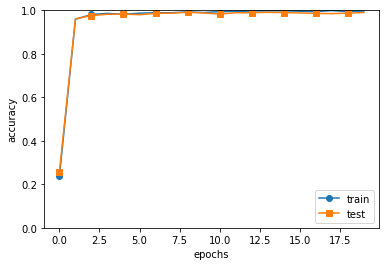

In [8]:
# %load train_convnet.py
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 处理花费时间较长的情况下减少数据 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 保存参数
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 绘制图形
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right') #显示图例
plt.show()


In [9]:
# %load gradient_check.py
import numpy as np
from simple_convnet import SimpleConvNet

network = SimpleConvNet(input_dim=(1,10, 10), 
                        conv_param = {'filter_num':10, 'filter_size':3, 'pad':0, 'stride':1},
                        hidden_size=10, output_size=10, weight_init_std=0.01)

X = np.random.rand(100).reshape((1, 1, 10, 10))
T = np.array([1]).reshape((1,1))

grad_num = network.numerical_gradient(X, T)
grad = network.gradient(X, T)

for key, val in grad_num.items():
    print(key, np.abs(grad_num[key] - grad[key]).mean())

W1 3.81513748478e-08
b1 1.43780165313e-06
W2 3.67238892518e-11
b2 3.11152520819e-09
W3 1.34977702247e-10
b3 1.79909564323e-07


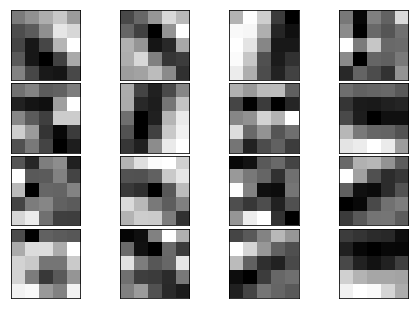

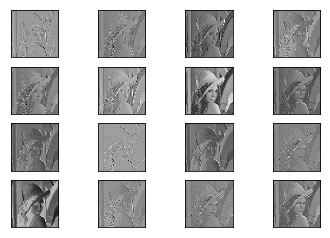

In [10]:
# %load apply_filter.py
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet
from matplotlib.image import imread
from common.layers import Convolution

def filter_show(filters, nx=4, show_num=16):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(show_num / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(show_num):
        ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')


network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

# 学习后的权重
network.load_params("params.pkl")

filter_show(network.params['W1'], 16)

img = imread('../dataset/lena_gray.png')
img = img.reshape(1, 1, *img.shape)

fig = plt.figure()

w_idx = 1

for i in range(16):
    w = network.params['W1'][i]
    b = 0  # network.params['b1'][i]

    w = w.reshape(1, *w.shape)
    #b = b.reshape(1, *b.shape)
    conv_layer = Convolution(w, b) 
    out = conv_layer.forward(img)
    out = out.reshape(out.shape[2], out.shape[3])
    
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(out, cmap=plt.cm.gray_r, interpolation='nearest')

plt.show()

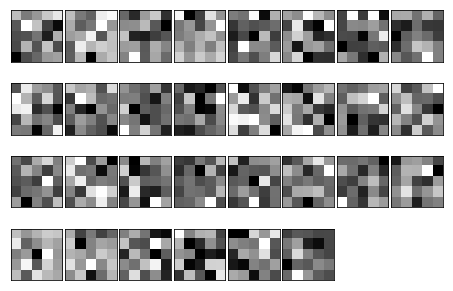

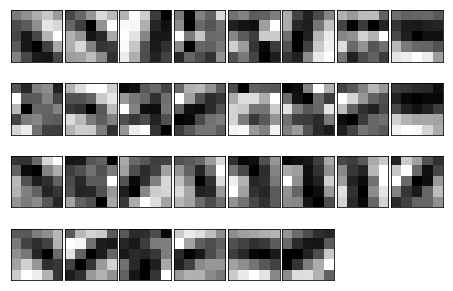

In [11]:
# %load visualize_filter.py
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()

#第一层卷积层的权重形状（30,1,5,5）
network = SimpleConvNet()
# 随机进行初始化后的权重
filter_show(network.params['W1'])

# 学习后的权重
network.load_params("params.pkl")
filter_show(network.params['W1'])